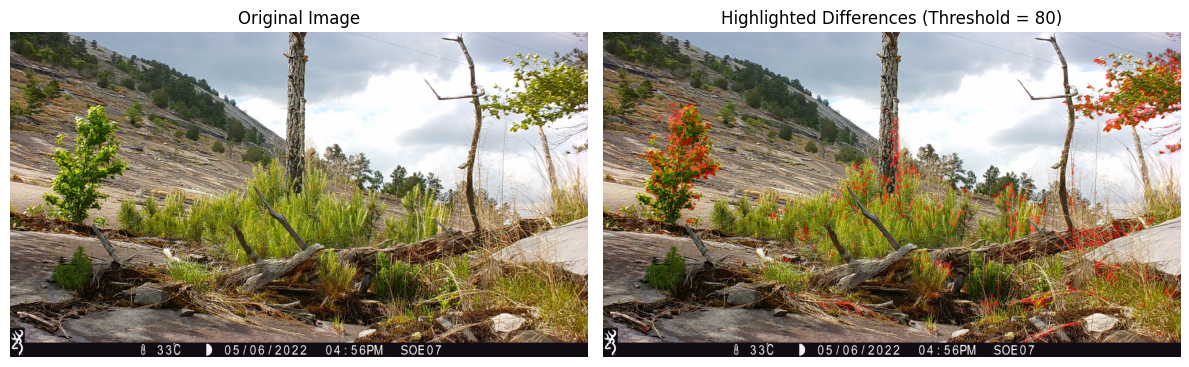

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys

# =========================================================
# 1) Load the three images
# =========================================================
img1 = cv2.imread('1.JPG')
img2 = cv2.imread('2.JPG')
img3 = cv2.imread('3.JPG')

# Verify they loaded correctly
for i, img in enumerate([img1, img2, img3], start=1):
    if img is None:
        sys.exit(f"❌ Error: Image {i}.JPG not found. Check the path or filename.")

# Resize to same size (important for comparison)
h, w = img1.shape[:2]
img2 = cv2.resize(img2, (w, h))
img3 = cv2.resize(img3, (w, h))

# =========================================================
# 2) Compute absolute pixel differences between images
# =========================================================
diff12 = cv2.absdiff(img1, img2)
diff23 = cv2.absdiff(img2, img3)
diff13 = cv2.absdiff(img1, img3)

# Combine all differences
combined_diff = cv2.bitwise_or(diff12, diff23)
combined_diff = cv2.bitwise_or(combined_diff, diff13)

# =========================================================
# 3) Convert to grayscale and apply a *higher threshold*
# =========================================================
gray = cv2.cvtColor(combined_diff, cv2.COLOR_BGR2GRAY)

# ⬆️ Increase threshold value from 30 → 80 (tune this value as needed)
_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

# Optional: smoothen small specks/noise
thresh = cv2.medianBlur(thresh, 5)

# =========================================================
# 4) Overlay the differences (red) on top of the first image
# =========================================================
overlay = img1.copy()
overlay[thresh > 0] = [0, 0, 255]   # red color marks difference

alpha = 0.5  # transparency control
highlighted = cv2.addWeighted(img1, alpha, overlay, 1 - alpha, 0)

# =========================================================
# 5) Display results
# =========================================================
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Highlighted Differences (Threshold = 80)')
plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


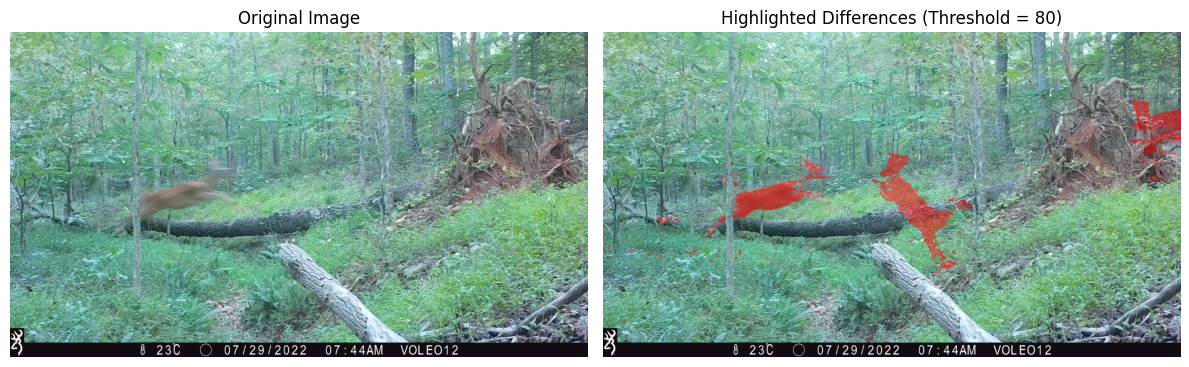

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys

# =========================================================
# 1) Load the three images
# =========================================================
img1 = cv2.imread('4.JPG')
img2 = cv2.imread('5.JPG')
img3 = cv2.imread('6.JPG')

# Verify they loaded correctly
for i, img in enumerate([img1, img2, img3], start=1):
    if img is None:
        sys.exit(f"❌ Error: Image {i}.JPG not found. Check the path or filename.")

# Resize to same size (important for comparison)
h, w = img1.shape[:2]
img2 = cv2.resize(img2, (w, h))
img3 = cv2.resize(img3, (w, h))

# =========================================================
# 2) Compute absolute pixel differences between images
# =========================================================
diff12 = cv2.absdiff(img1, img2)
diff23 = cv2.absdiff(img2, img3)
diff13 = cv2.absdiff(img1, img3)

# Combine all differences
combined_diff = cv2.bitwise_or(diff12, diff23)
combined_diff = cv2.bitwise_or(combined_diff, diff13)

# =========================================================
# 3) Convert to grayscale and apply a *higher threshold*
# =========================================================
gray = cv2.cvtColor(combined_diff, cv2.COLOR_BGR2GRAY)

# ⬆️ Increase threshold value from 30 → 80 (tune this value as needed)
_, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

# Optional: smoothen small specks/noise
thresh = cv2.medianBlur(thresh, 5)

# =========================================================
# 4) Overlay the differences (red) on top of the first image
# =========================================================
overlay = img1.copy()
overlay[thresh > 0] = [0, 0, 255]   # red color marks difference

alpha = 0.5  # transparency control
highlighted = cv2.addWeighted(img1, alpha, overlay, 1 - alpha, 0)

# =========================================================
# 5) Display results
# =========================================================
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Highlighted Differences (Threshold = 80)')
plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


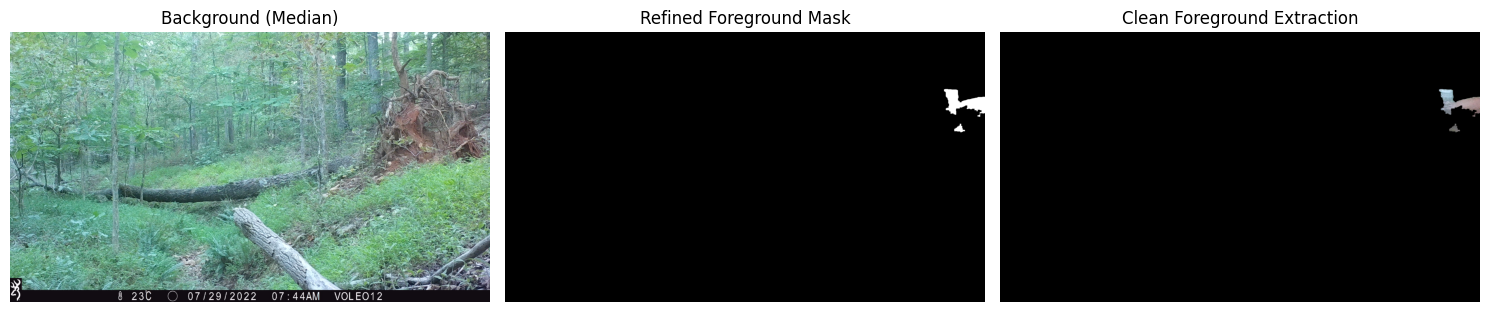

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys

# =========================================================
# 1) Load images
# =========================================================
filenames = ['4.JPG', '5.JPG', '6.JPG']
images = [cv2.imread(f) for f in filenames]

for i, img in enumerate(images, start=1):
    if img is None:
        sys.exit(f"❌ Error: Image {i}.JPG not found or unreadable.")

# Resize all to same size
h, w = images[0].shape[:2]
images = [cv2.resize(img, (w, h)) for img in images]

# =========================================================
# 2) Align images to the first one using ORB feature matching
# =========================================================
def align_image(img_ref, img_to_align):
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img_ref, None)
    kp2, des2 = orb.detectAndCompute(img_to_align, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Use top matches
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches[:100]]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches[:100]]).reshape(-1, 1, 2)

    # Estimate homography
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)
    aligned = cv2.warpPerspective(img_to_align, H, (w, h))
    return aligned

aligned_images = [images[0]] + [align_image(images[0], img) for img in images[1:]]

# =========================================================
# 3) Compute median background from aligned images
# =========================================================
stack = np.stack(aligned_images, axis=3)
background = np.median(stack, axis=3).astype(np.uint8)

# =========================================================
# 4) Subtract background more robustly to get moving objects
# =========================================================

# Use the middle aligned image as main frame
frame = aligned_images[1]

# Slight blur to reduce noise before diff
blur_frame = cv2.GaussianBlur(frame, (5, 5), 0)
blur_bg = cv2.GaussianBlur(background, (5, 5), 0)

# Compute color distance (L2 norm across channels)
diff = np.sqrt(np.sum((blur_frame.astype(np.float32) - blur_bg.astype(np.float32))**2, axis=2))
diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Threshold difference to get mask (tune threshold)
_, mask = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

# =========================================================
# 5) Clean mask with morphological operations
# =========================================================
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))

# Optionally remove tiny blobs (contours < 500 px)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
clean_mask = np.zeros_like(mask)
for c in contours:
    if cv2.contourArea(c) > 500:  # keep only large areas
        cv2.drawContours(clean_mask, [c], -1, 255, -1)
mask = clean_mask

# =========================================================
# 6) Extract clean foreground
# =========================================================
foreground = cv2.bitwise_and(frame, frame, mask=mask)

# =========================================================
# 7) Show results
# =========================================================
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Background (Median)')
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Refined Foreground Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Clean Foreground Extraction')
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()